In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils 
from utils import stats_utils, segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 
from feature_extraction import texture_statistics_pyramid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse
import pandas as pd
from skimage import io
import copy

from matplotlib import pyplot as plt
import PIL



Initializing coco api...
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=14.73s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=12.33s)
creating index...
index created!


In [2]:
for ss in range(8):
    coco_utils.write_binary_labels_csv(ss+1)

Gathering coco labels for subject 1
Saving to /user_data/mmhender/nsd_stimuli/labels/S1_cocolabs_binary.csv
Gathering coco labels for subject 2
Saving to /user_data/mmhender/nsd_stimuli/labels/S2_cocolabs_binary.csv
Gathering coco labels for subject 3
Saving to /user_data/mmhender/nsd_stimuli/labels/S3_cocolabs_binary.csv
Gathering coco labels for subject 4
Saving to /user_data/mmhender/nsd_stimuli/labels/S4_cocolabs_binary.csv
Gathering coco labels for subject 5
Saving to /user_data/mmhender/nsd_stimuli/labels/S5_cocolabs_binary.csv
Gathering coco labels for subject 6
Saving to /user_data/mmhender/nsd_stimuli/labels/S6_cocolabs_binary.csv
Gathering coco labels for subject 7
Saving to /user_data/mmhender/nsd_stimuli/labels/S7_cocolabs_binary.csv
Gathering coco labels for subject 8
Saving to /user_data/mmhender/nsd_stimuli/labels/S8_cocolabs_binary.csv


In [2]:
for ss in range(8):
    coco_utils.write_binary_labels_csv(ss+1, stuff=True)

Gathering coco labels for subject 1
Saving to /user_data/mmhender/nsd_stimuli/labels/S1_cocolabs_stuff_binary.csv
Gathering coco labels for subject 2
Saving to /user_data/mmhender/nsd_stimuli/labels/S2_cocolabs_stuff_binary.csv
Gathering coco labels for subject 3
Saving to /user_data/mmhender/nsd_stimuli/labels/S3_cocolabs_stuff_binary.csv
Gathering coco labels for subject 4
Saving to /user_data/mmhender/nsd_stimuli/labels/S4_cocolabs_stuff_binary.csv
Gathering coco labels for subject 5
Saving to /user_data/mmhender/nsd_stimuli/labels/S5_cocolabs_stuff_binary.csv
Gathering coco labels for subject 6
Saving to /user_data/mmhender/nsd_stimuli/labels/S6_cocolabs_stuff_binary.csv
Gathering coco labels for subject 7
Saving to /user_data/mmhender/nsd_stimuli/labels/S7_cocolabs_stuff_binary.csv
Gathering coco labels for subject 8
Saving to /user_data/mmhender/nsd_stimuli/labels/S8_cocolabs_stuff_binary.csv


In [2]:
# Get ready for some tests - load basic things for a subject
subject = 2
ims = nsd_utils.get_image_data(subject, native=True)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])


Loading images for subject 2

image data size: (10000, 3, 425, 425) , dtype: uint8 , value range: 0 255


things labels:
['appliance', 'furniture', 'indoor', 'kitchen']
['bottle', 'potted plant', 'toilet', 'sink', 'toothbrush']
stuff labels:
['furniture-stuff', 'other', 'raw-material', 'textile', 'wall', 'window']
['cabinet', 'curtain', 'furniture-other', 'mirror-stuff', 'napkin', 'paper', 'towel', 'wall-concrete', 'wall-other', 'wall-stone', 'window-other', 'other.1']


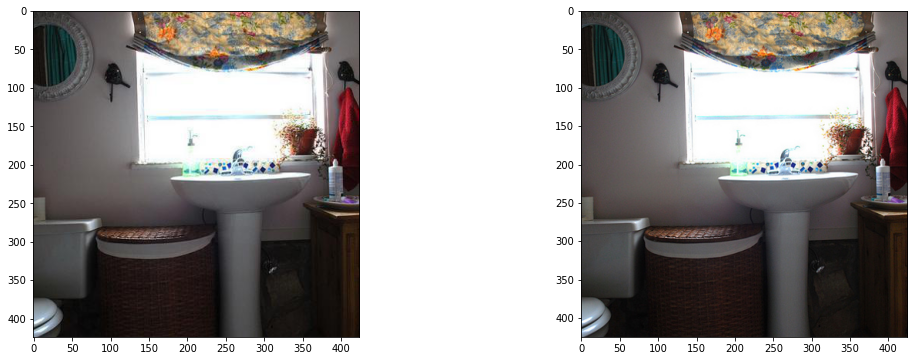

In [3]:
# Check the coco labels for example image

image_ind = np.random.choice(np.arange(0,10000), 1)[0]
# image_ind = 1

# Print things labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:12]
cat_names = list(df.keys()[12:92])

print('things labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# Print stuff labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_stuff_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:16]
cat_names = list(df.keys()[16:108])

print('stuff labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(np.moveaxis(ims[image_ind,:,:,:],[0,1,2],[2,0,1]))

In [5]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

prf_ind = 697
# prf_ind = 215
# prf_ind = 831
# prf_ind = 512


prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
n_pix = 425
aperture=1.0
prf = prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                                      dtype=np.float32)[2]
n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [118]:
np.where((np.round(models[:,0],2)==0.0) & ((np.round(models[:,1],2)==0.0)))

(array([512, 685, 866]),)

In [106]:
models[831]

array([0.11      , 0.11      , 0.14910375])

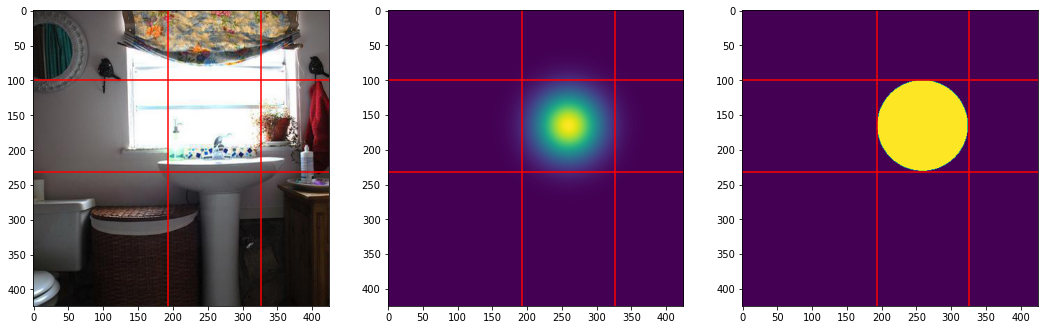

In [6]:
# Check pRF bounding boxes

plt.figure(figsize=(18,6));
plt.subplot(1,3,1)
plt.imshow(im)
# show the prf on top to make sure it is where it should be
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')


plt.subplot(1,3,2)
plt.imshow(prf/np.max(prf))
# plt.colorbar()
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

# Creating a mask 2 SD from the center
# cutoff of 0.14 approximates +/-2 SDs
prf_mask = prf/np.max(prf)>0.14

plt.subplot(1,3,3)
plt.imshow(prf_mask)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')


In [7]:
# Now checking the annotation labels within pRFs separately 

# Get things annotations for this image
cocoid = np.array(subject_df['cocoId'])[image_ind]
# figure out if it's training or val set and create the right coco api dataset
if np.array(subject_df['cocoSplit'])[image_ind]=='val2017':
    coco = coco_utils.coco_val 
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
else:
    coco = coco_utils.coco_trn
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/train2017'
      
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_utils.coco_val)

        
annotations = coco.loadAnns(coco.getAnnIds(imgIds=[cocoid]))
masks = np.array([coco.annToMask(annotations[aa]) for aa in range(len(annotations))])

# Print all the categories that are annotated anywhere in the image
print('in whole image:')
ann_cats = [annotations[aa]['category_id'] for aa in range(len(annotations))]
print(ann_cats)
ann_cat_names = [cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in ann_cats]
print(ann_cat_names)

# How was the image cropped to get from coco original to NSD?
# Need this to know how to adjust object segmentations
img_info = coco.loadImgs(ids=[cocoid])[0]
crop_box_pixels = segmentation_utils.get_crop_box_pixels(np.array(subject_df['cropBox'])[image_ind], \
                                                         [img_info['height'], img_info['width']])

# Figure out which annotations overlap with my pRF of interest (defined above)
masks_final = np.zeros((masks.shape[0], n_pix, n_pix))
for aa in range(len(annotations)):
    
    mask = masks[aa,:,:]
    mask_cropped = mask[crop_box_pixels[0]:crop_box_pixels[1], crop_box_pixels[2]:crop_box_pixels[3]]
    newsize=[n_pix, n_pix]
    mask_cropped_resized = np.asarray(PIL.Image.fromarray(mask_cropped).resize(newsize, resample=PIL.Image.BILINEAR))

    masks_final[aa,:,:] = mask_cropped_resized

min_overlap_pix = 10
has_overlap = np.tensordot(masks_final, prf_mask, [[1,2], [0,1]])>min_overlap_pix

print('\nin pRF:')
print(has_overlap)

print(np.array(ann_cats)[has_overlap])
print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in np.array(ann_cats)[has_overlap]])
print([supcat_names[sc] for sc in range(len(supcat_names)) \
    if np.any(np.isin(np.array(ann_cats)[has_overlap] , ids_each_supcat[sc]))])

in whole image:
[44, 90, 90, 70, 81, 64, 90]
['bottle', 'potted plant', 'toilet', 'sink', 'toothbrush']

in pRF:
[False False False False  True  True False]
[81 64]
['potted plant', 'sink']
['appliance', 'furniture']


In [17]:
# Make sure my saved labels match this same thing

df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                             'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
print([kk for kk in df.keys() if df[kk].loc[image_ind]==1])


['appliance', 'furniture', 'potted plant', 'sink']


In [23]:
os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                             'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_ind))

'/user_data/mmhender/nsd_stimuli/labels/S2_within_prf/S2_cocolabs_binary_prf697.csv'

In [22]:
np.mean(df['animal']==1)

0.1704

True
81
['sink']


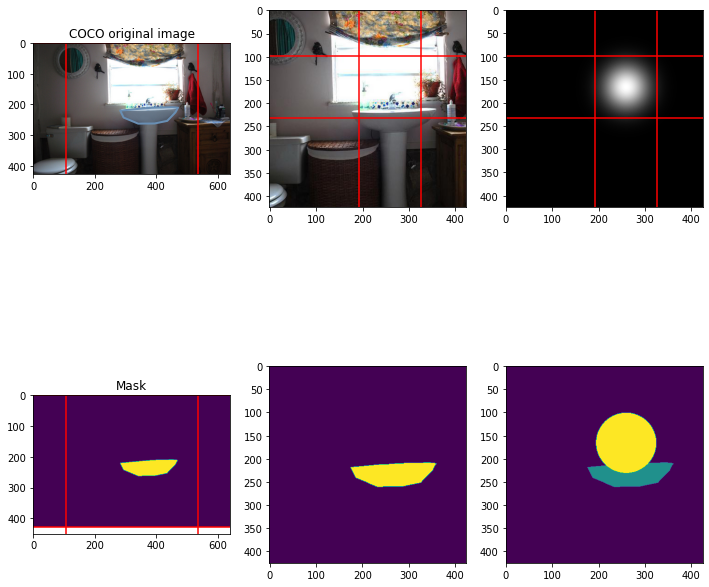

In [9]:
# Now visualizing the actual masks
if np.any(has_overlap==1):
    annot2plot = np.where(has_overlap==1)[0][0]
#     annot2plot = 2
else:
    annot2plot = 0
    
plt.figure(figsize=(12,12));

plt.subplot(2,3,1)
imfn = os.path.join(coco_image_dir, img_info['file_name'])
coco_im = io.imread(imfn)
plt.imshow(coco_im); plt.title('COCO original image')
# coco.showAnns(annotations)
coco.showAnns([annotations[annot2plot]])
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,2)
plt.imshow(im)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,3)
plt.imshow(prf,cmap='gray')
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,4)

mask = masks[annot2plot,:,:]

plt.imshow(mask); plt.title('Mask')
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,5)
mask_cropped_resized = masks_final[annot2plot,:,:]
plt.imshow(mask_cropped_resized)

plt.subplot(2,3,6)
mask_plus_prf = copy.deepcopy(mask_cropped_resized)
# prf_masked = np.zeros(np.shape(prf))
mask_plus_prf[prf_mask==1] = 2
# mask_plus_prf[prf_bbox[0]:prf_bbox[1], prf_bbox[2]:prf_bbox[3]] = 2
plt.imshow(mask_plus_prf)
# plt.gca().invert_yaxis()

min_overlap_pix = 10
mask_has_overlap = np.tensordot(masks_final[annot2plot], prf_mask, [[0,1], [0,1]])>min_overlap_pix
# mask_has_overlap = np.sum(masks_final[annot2plot,prf_bbox[0]:prf_bbox[1], prf_bbox[2]:prf_bbox[3]])>min_overlap_pix
print(mask_has_overlap)

print(ann_cats[annot2plot])

print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in [np.array(ann_cats)[annot2plot]]])


In [10]:
# Now same thing but with the STUFF labels

# Get things annotations for this image
cocoid = np.array(subject_df['cocoId'])[image_ind]
# figure out if it's training or val set and create the right coco api dataset
if np.array(subject_df['cocoSplit'])[image_ind]=='val2017':
    coco = coco_utils.coco_stuff_val 
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
else:
    coco = coco_utils.coco_stuff_trn
    coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/train2017'
      
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val)

        
annotations = coco.loadAnns(coco.getAnnIds(imgIds=[cocoid]))
masks = np.array([coco.annToMask(annotations[aa]) for aa in range(len(annotations))])

# Print all the categories that are annotated anywhere in the image
print('in whole image:')
ann_cats = [annotations[aa]['category_id'] for aa in range(len(annotations))]
print(ann_cats)
ann_cat_names = [cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in ann_cats]
print(ann_cat_names)

# How was the image cropped to get from coco original to NSD?
# Need this to know how to adjust object segmentations
img_info = coco.loadImgs(ids=[cocoid])[0]
crop_box_pixels = segmentation_utils.get_crop_box_pixels(np.array(subject_df['cropBox'])[image_ind], \
                                                         [img_info['height'], img_info['width']])

# Figure out which annotations overlap with my pRF of interest (defined above)
masks_final = np.zeros((masks.shape[0], n_pix, n_pix))
for aa in range(len(annotations)):
    
    mask = masks[aa,:,:]
    mask_cropped = mask[crop_box_pixels[0]:crop_box_pixels[1], crop_box_pixels[2]:crop_box_pixels[3]]
    newsize=[n_pix, n_pix]
    mask_cropped_resized = np.asarray(PIL.Image.fromarray(mask_cropped).resize(newsize, resample=PIL.Image.BILINEAR))

    masks_final[aa,:,:] = mask_cropped_resized

min_overlap_pix = 10
has_overlap = np.tensordot(masks_final, prf_mask, [[1,2], [0,1]])>min_overlap_pix
# has_overlap = np.sum(np.sum(masks_final[:,prf_bbox[0]:prf_bbox[1], prf_bbox[2]:prf_bbox[3]],\
#                             axis=2),axis=1)>min_overlap_pix
print('\nin pRF:')
print(has_overlap)

print(np.array(ann_cats)[has_overlap])
print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in np.array(ann_cats)[has_overlap]])
print([supcat_names[sc] for sc in range(len(supcat_names)) \
if np.any(np.isin(np.array(ann_cats)[has_overlap] , ids_each_supcat[sc]))])

in whole image:
[98, 109, 123, 133, 137, 139, 168, 172, 173, 175, 181, 183]
['cabinet', 'curtain', 'furniture-other', 'mirror-stuff', 'napkin', 'paper', 'towel', 'wall-concrete', 'wall-other', 'wall-stone', 'window-other', 'other']

in pRF:
[False False False False False False False  True False False  True  True]
[172 181 183]
['wall-concrete', 'window-other', 'other']
['other', 'wall', 'window']


In [16]:
# Make sure my saved labels match this same thing

df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                             'S%d_cocolabs_stuff_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
print([kk for kk in df.keys() if df[kk].loc[image_ind]==1])


['other', 'wall', 'window', 'wall-concrete', 'window-other', 'other.1']


True
['wall-concrete']
172


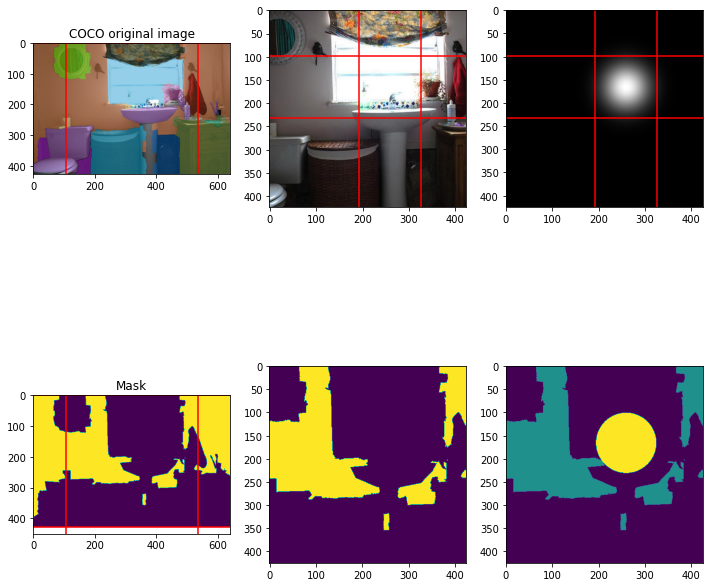

In [12]:
# Now visualizing the actual masks
if np.any(has_overlap==1):
    annot2plot = np.where(has_overlap==1)[0][0]
else:
    annot2plot = 0
    
plt.figure(figsize=(12,12));

plt.subplot(2,3,1)
imfn = os.path.join(coco_image_dir, img_info['file_name'])
coco_im = io.imread(imfn)
plt.imshow(coco_im); plt.title('COCO original image')
coco.showAnns(annotations)
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,2)
plt.imshow(im)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,3)
plt.imshow(prf,cmap='gray')
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,4)

mask = masks[annot2plot,:,:]

plt.imshow(mask); plt.title('Mask')
plt.axhline([crop_box_pixels[0]],color='r')
plt.axhline([crop_box_pixels[1]],color='r')
plt.axvline([crop_box_pixels[2]],color='r')
plt.axvline([crop_box_pixels[3]],color='r')

plt.subplot(2,3,5)
mask_cropped_resized = masks_final[annot2plot,:,:]
plt.imshow(mask_cropped_resized)

plt.subplot(2,3,6)
# mask_plus_prf = copy.deepcopy(prf_mask).astype('int')
# mask_plus_prf[mask_cropped_resized==1] = 2
mask_plus_prf = copy.deepcopy(mask_cropped_resized)
mask_plus_prf[prf_mask==1] = 2

plt.imshow(mask_plus_prf)
# plt.gca().invert_yaxis()

min_overlap_pix = 10
mask_has_overlap = np.tensordot(masks_final[annot2plot], prf_mask, [[0,1], [0,1]])>min_overlap_pix
print(mask_has_overlap)

print([cat_names[cc] for cc in range(len(cat_names)) \
                if cat_ids[cc] in [np.array(ann_cats)[annot2plot]]])
print(ann_cats[annot2plot])
